<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">TP : oscillateurs
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Oscillateurs | OQS de Wien
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib widget

# import des librairies 
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#  Oscillateur quasi-sinusoïdal à filtre de Wien
On s'intéresse au circuit ci-dessous dans lequel un montage amplificateur à ALI est couplé à un filtre passe-bande de Wien :
<img src="fig1.png" style="height:350px">
En régime linéaire, la partie ALI a pour fonction de transfert :
$$\underline{H}_\text{ALI}=\dfrac{R_1+R_2}{R_2}$$
La partie filtre de Wien a pour fonction de transfert :
$$\underline{H}_\text{Wien}=\dfrac{\text{j}RC\omega}{1+3\text{j}RC\omega-R^2C^2\omega^2}$$

&nbsp;
En exploitant les deux relations ci-dessus, et la condition de bouclage, on peut établir l'équation différentielle de l'oscillateur, en régime linéaire : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2u_s}{\text{d}t^2}+\dfrac{RC}{R_2}(2R_2-R_1)\dfrac{\text{d}u_s}{\text{d}t}+u_s=0
}$$

En régime de saturation, il faut s'intérsser à la condition de bascule de $+U_\text{sat}$ à $-U_\text{sat}$ et vice-versa. On montre que l'ALI :
* reste en saturation positive tant que $u_s<\frac{R_2}{R_1+R_2}U_\text{sat}$, et obéit alors à l'équation différentielle : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2u_s}{\text{d}t^2}+3RC\dfrac{\text{d}u_s}{\text{d}t}+u_s=0
}$$
* reste en saturation négative tant que $u_s<-\frac{R_2}{R_1+R_2}U_\text{sat}$, et obéit alors à l'équation différentielle : 
$$\boxed{
R^2C^2\dfrac{\text{d}^2u_s}{\text{d}t^2}+3RC\dfrac{\text{d}u_s}{\text{d}t}+u_s=0
}$$

&nbsp;
Les deux équations différentielles sont du deuxième ordre à coefficients constants et font apparaître la même pulsation propre $\omega_0=1/RC$. La première est conditionnellement stable, et la deuxième toujours stable. 

&nbsp;
L'apparition d'oscillations n'est possible que si la première équation différentielle est instable, soit $R_1>2R_2$.

&nbsp;
On crée donc les variables associées aux diverses grandeurs, ainsi qu'une condition initiale de "bruit électronique", sous la forme d'un vecteur `xv0` qui contient une tension nulle, mais une dérivée initiale non nulle.

In [2]:
### Données propres aux divers blocs électrocinétiques
## Montage amplificateur à ALI
R1 = 100000. # résistance N°1 de l'amplificateur
R2 = 10000. # résistance N°2 de l'amplificateur
Usat = 15. # tension de saturation de l'ALI

## Montage filtre passe-bande de Wien
R = np.mean([9.94e3, 9.90e3, 9.99e3]) # résistance du filtre
u_R = np.std([9.94e3, 9.90e3, 9.99e3], ddof=1)
C = np.mean([100.2e-9, 96.7e-9, 94.9e-9]) # capacité du filtre
u_C = np.std([100.2e-9, 96.7e-9, 94.9e-9], ddof=1)

## Calcul de la valeur moyenne de omega0 et de son incertitude de mesure
omega0_store = []
for i in range(100000):
    omega0_store.append(1/((R+np.random.uniform(-1,1)*u_R)*(C+np.random.uniform(-1,1)*u_C))) # pulsation propre
omega0 = np.mean(omega0_store)
u_omega0 = np.std(omega0_store, ddof=1)

## Bruit électronique initial servant de condition initiale
xv0 = [0,1e-3*2*np.pi*omega0]

### Paramètres numériques d'intégration
Tmax = 100*(2*np.pi/omega0)
nd = 50000
t = np.linspace(0.0,Tmax,nd)

On code alors l'équation différentielle sous la forme vectorielle compatible avec `odeint` :
$$\dfrac{\text{d}}{\text{d}t}X=f(X,t)$$

où $X=\left[\begin{array}{c} u_s \\ \dot{u_s} \end{array}\right]$ est la grandeur que l'on cherche à résoudre, on la note `xv`.

et la fonction vectorielle $f$, codé sous le nom `osc_QS_wien`, dépend du résultat obtenu pour $u_s$ :
* si $\left|u_s\right|\leq \frac{R_2}{R_1+R_2}U_\text{sat}$ : 
$$f(X,t)=\left[\begin{array}{c} \dot{u_s} \\ -\frac{1}{R^2C^2}u_s-\frac{2R_2-R_1}{CR_2R_1}\dot{u_s} \end{array}\right]$$
* sinon 
$${f(X,t)=\left[\begin{array}{c} \dot{u_s} \\ -\frac{1}{R^2C^2}u_s-\frac{3}{RC}\dot{u_s} \end{array}\right]}$$

In [3]:
### Fonction décrivant le comportement de l'oscillateur
def osc_QS_wien(xv,t): 
    # Si la tension de sortie est plus faible que la condition de bascule le montage est instable
    if abs(xv[0]) <= (R2/(R1+R2))*Usat :
        return [xv[1],-(2*R2-R1)/(C*R2*R)*xv[1]-xv[0]/((R*C)**2)]
    # Sinon le montage est stabilisé par le passage en saturation de l'ALI
    else :
        return [xv[1],-3/(R*C)*xv[1]-xv[0]/((R*C)**2)]

In [4]:
### Intégration numérique à l'aide d'odeint et des conditions initiales de bruit
xv = odeint(osc_QS_wien,xv0,t)
# extraction des données de tension et de sa dérivée pour un diagramme de phase
X = xv[:,0]
Xpoint = xv[:,1]

Une fois l'équation résolue, on peut tracer les fonctions suivantes : 
* loi horaire ;
* spectre fréquentiel.

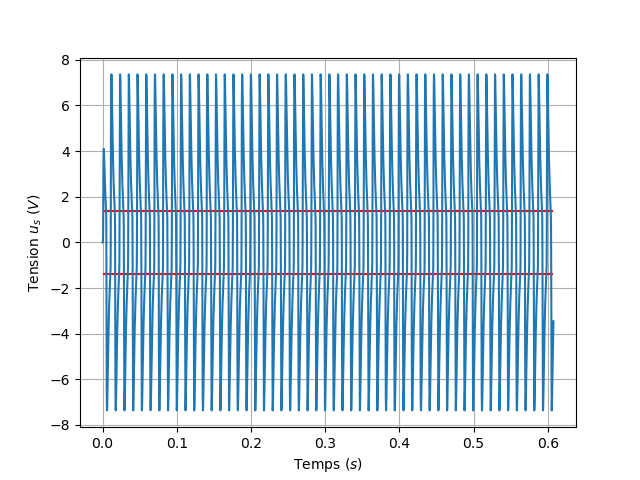

In [5]:
## On trace l'évolution temporelle de la tension de sortie du filtre
plt.figure('Signal')
plt.plot(t,X)
plt.hlines(R2*Usat/(R1+R2),min(t),max(t),color='r')
plt.hlines(-R2*Usat/(R1+R2),min(t),max(t),color='r')
plt.grid(True)
plt.xlabel(r'Temps $(s)$')
plt.ylabel(r'Tension $u_s$ $(V)$')
plt.show()

Les lignes rouges représentent les frontières $\left|u_s\right|\leq \frac{R_2}{R_1+R_2}U_\text{sat}$. On peut alors remarquer l'effet stabilisant du fonctionnement en saturation de l'ALI.

La bascule périodique entre régime linéaire et de saturation du fonctionnement de l'ALI a pour conséquence un enrichissement spectral du signal obtenu, d'autant plus flagrant que la durée passée en mode de saturation est grande.

&nbsp;
On peut le vérifier en traçant le spectre du signal, et en modifiant les paramètres de fonctionnement de l'oscillateur.

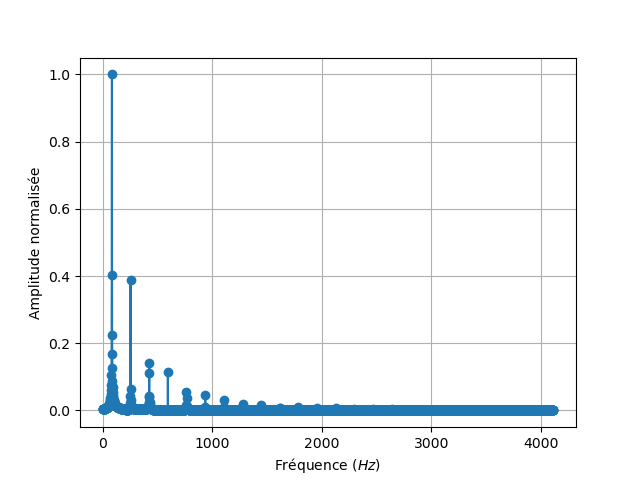

La fréquence dominante du signal de sortie est :  8.559e+01 +/- 9.503e-01 Hz
La fréquence propre est :  1.646e+02 Hz


In [6]:
## On utilise le module fft.fft de scipy
Y = np.abs(np.fft.rfft(X)/(len(X)//2+1))
nf=nd/20 # Affichage réduit de la plage de fréquences calculées
Y = Y[:int(nf)]
frq = np.fft.rfftfreq(len(X), d=Tmax/(nd-1)) # Création de l'axe des abscisses
frq = frq[:int(nf)]
imax=np.argmax(Y) # On cherche la valeur maximale de la FFT pour normalisation

plt.figure('FFT')
plt.plot(frq,Y/np.max(Y), '-o')
plt.grid(True)
plt.xlabel(r'Fréquence $(Hz)$')
plt.ylabel(r'Amplitude normalisée')
plt.show()

print("La fréquence dominante du signal de sortie est : ",format(frq[imax],"#.3e"),"+/-", format((frq[1]-frq[0])/np.sqrt(3), "#.3e"),"Hz")
print("La fréquence propre est : ",format(omega0/(2*np.pi),"#.3e"),"Hz")

Les résultats de fréquences calculées par simulation et mesurées expérimentalement pour diverses valeurs de $R_1$ sont récapitulées ci-dessous :

In [7]:
R1_exp = [20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 90000, 100000]
u_R1_exp = [i/100 for i in R1_exp]
f_num = [164.6, 154.7, 143.2, 133.3, 126.7, 120.2, 113.6, 108.6, 105.3, 102.0, 98.8, 95.5, 93.8, 93.8, 93.8, 92.2, 92.2, 92.2, 92.2, 88.9, 85.6]
f_exp = [162.1, 151.3, 139.9, 130.4, 122.6, 116.0, 110.6, 105.9, 101.9, 098.4, 95.3, 92.6, 91.6, 91.1, 90.6, 90.2, 89.7, 89.3, 88.8, 86.0, 82.5]
u_f_num = len(R1_exp)*[.95]
u_f_exp =len(f_exp)*[.1]

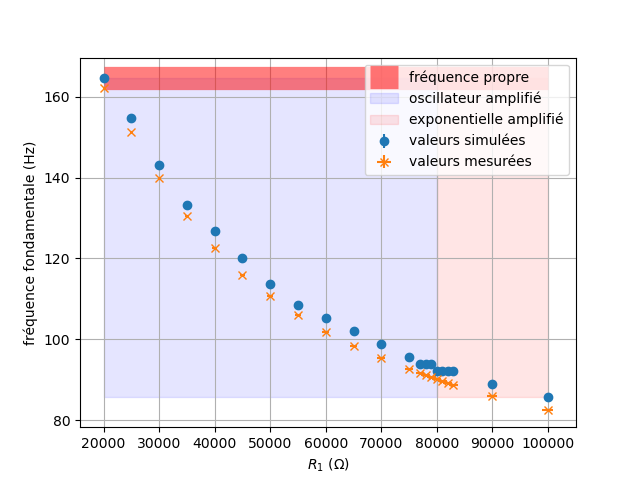

L'écart relatif moyen entre les valeurs mesurées et les valeurs simulées de fréquence est : 3.0e+00 %


In [8]:
plt.figure()
plt.hlines(omega0/(2*np.pi), xmin=np.min(R1_exp), xmax=np.max(R1_exp), label='fréquence propre', color='r', linewidth=u_omega0, alpha = .5)
plt.errorbar(R1_exp, f_num, yerr=u_f_num, fmt='o', label = 'valeurs simulées')
plt.errorbar(R1_exp, f_exp, xerr=u_R1_exp, yerr=u_f_exp, fmt='x', label = 'valeurs mesurées')
plt.fill_between([20000, 80000], y1 = np.min([omega0/(2*np.pi)]+f_num), y2 =np.max([omega0/(2*np.pi)]+f_num), color = 'blue', alpha = .1, label="oscillateur amplifié")
plt.fill_between([80000, np.max(R1_exp)], y1 = np.min([omega0/(2*np.pi)]+f_num), y2 =np.max([omega0/(2*np.pi)]+f_num), color = 'red', alpha = .1, label="exponentielle amplifié")
plt.xlabel(r'$R_1~(\Omega)$')
plt.ylabel('fréquence fondamentale (Hz)')
plt.legend()
plt.grid(True)
plt.show()

err_moy=np.mean(np.abs((np.array(f_num)-np.array(f_exp))/np.array(f_exp)))

print("L'écart relatif moyen entre les valeurs mesurées et les valeurs simulées de fréquence est :", format(err_moy*100, "#.1e"), "%")

# Mise en commun des valeurs de chaque groupe

In [9]:
R_critique=[20090, 20060, 20080, 19670, 20010, 20210, 20340, 19510]
R_critique_moy = np.mean(R_critique)
u_R_critique=np.std(R_critique, ddof=1)
f_OH=[160.1, 160.7, 157.3, 162.3, 165.8, 159.4, 167.5, 162.5]
f_OH_moy = np.mean(f_OH)
u_f_OH = np.std(f_OH, ddof=1)
print("La résistance critique moyenne obtenue par la classe est ", format(R_critique_moy, "#.2e"),"+/-", format(u_R_critique, "#.3e"), "Ohm")
print("La fréquence moyenne obtenue par la classe est ", format(f_OH_moy, "#.2e"),"+/-", format(u_f_OH, "#.3e"), "Hz")


La résistance critique moyenne obtenue par la classe est  2.00e+04 +/- 2.743e+02 Ohm
La fréquence moyenne obtenue par la classe est  1.62e+02 +/- 3.363e+00 Hz
